# Normalized Difference Vegetation Index (NDVI)

Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health.It is calculated based on how plants reflect certain ranges of the electromagnetic spectrum.A healthy plant—one with a lot of chlorophyll and cell structures—actively absorbs red light and reflects NIR. An unhealthy plant will do the exact opposite.Satellite sensors in space measure wavelengths of light absorbed and reflected by green plants.The simple mathematical formula (below) calculates the NDVI and, in turn, transforms raw satellite data into vegetation indices which is defined as

$NDVI = \frac{(NIR - RED)}{(NIR+RED)}$

Geospatial Analytics has the necessary NIR and RED Sentinel 2 A/B satellite data which has helped us derive NDVI using the above formula.
We also provide flexibility to users to derive their own NDVI data using the available NIR and RED data as part of a UDF expression. Refer to [the tutorials](https://pairs.res.ibm.com/tutorial/legacy/api/v01x/udfs.html) for details on UDFs.

However, in this sample we'll be directly utilizing the already caliberated and stored NDVI data for simplicity.
References:
- https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
- https://www.researchgate.net/figure/Reference-NDVI-values-for-different-land-areas_tbl1_263004601
- https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/normalized-difference-vegetation-index

Before starting, you have to install ibm pairs using `pip3 install -U ibmpairs`

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial Analytics API credentials in a file named `secrets.ini` in the below format:

```
[EIS]
api.host = https://api.ibm.com/geospatial/run/na/core/v3
api.key = <Your Geospatial Analytics API key>
api.tenant_id = <Your Geospatial Analytics Tenant ID>
api.org_id = <Your Geospatial Analytics Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [13]:
import configparser
import pandas as pd
import ibmpairs.authentication as authentication #deals with PAIRS authentication using our credentials
import ibmpairs.client as client                 # represents an authenticated HTTP client
import ibmpairs.query as query                   # manages the submission of queries and retrieval of results
import sys, os,  datetime
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import requests
import json
import time
import base64
import random
import rasterio                
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file in the same
# directory as this notebook. You could set the credentials in-line here but we don't
# recommend it for security reasons.
EIS_HOST       = config.get('EIS', 'api.host')
EIS_API_KEY    = config.get('EIS', 'api.key')
EIS_TENANT_ID  = config.get('EIS', 'api.tenant_id') 
EIS_ORG_ID     = config.get('EIS', 'api.org_id')  

p2_credentials  = client.get_client(api_key   = EIS_API_KEY,
                                    tenant_id = EIS_TENANT_ID,
                                    org_id    = EIS_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )


2024-06-17 10:44:00 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-17 10:44:00 - paw - INFO - Legacy Environment is False
2024-06-17 10:44:00 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-17 10:44:01 - paw - INFO - Authentication success.
2024-06-17 10:44:01 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


First,let's make a point query to fetch the NDVI values from Geospatial Analytics layer 49464, the High resolution imagery (ESA Sentinel 2) dataset, for a location somewhere in south of Australia for the coordinates -38.26879,142.18045 (latitude/longitude). We've picked the coordinates in such a way that it covers a farmland to illustrate the use case of NDVI better.
Point queries help explore the data when unsure about it's spatial coverage frequency, or temporal extent.
The layer ID used here can be found using the catalogue sub-module.

In [14]:
query_json = {
      "layers" : [
          {"type" : "raster", "id" : "49464"}
      ],
      "spatial" : {
          "type" : "point",
          "coordinates" : ["-38.26879","142.18045"] #Farmland in Australia
      },
      "temporal" : {"intervals" : [
          {"start" : "2020-01-01T00:00:00Z", "end" : "2021-12-30T00:00:00Z"}
      ]}
  }

# Submit the query
query_result = query.submit(query_json)
# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
# Convert the timestamp to a human readable format
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
point_df

2024-06-17 10:44:06 - paw - INFO - TASK: submit STARTING.
2024-06-17 10:44:48 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,timestamp,longitude,latitude,value,datetime
0,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1577836800000,142.18045,-38.26879,0.2067000000000001,2020-01-01
1,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578096000000,142.18045,-38.26879,0.03839999999999999,2020-01-04
2,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578268800000,142.18045,-38.26879,0.48850000000000016,2020-01-06
3,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578528000000,142.18045,-38.26879,0.4710000000000001,2020-01-09
4,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578700800000,142.18045,-38.26879,0.01639999999999997,2020-01-11
...,...,...,...,...,...,...,...,...
282,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1639872000000,142.18045,-38.26879,-0.0038999999999999035,2021-12-19
283,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640044800000,142.18045,-38.26879,0.09079999999999999,2021-12-21
284,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640304000000,142.18045,-38.26879,0.5502,2021-12-24
285,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640476800000,142.18045,-38.26879,0.07390000000000008,2021-12-26


Geospatial Analytics returns approximately 300 rows of data, which are now stored in the point_df dataframe.
We can see the range of values returned for the location specified against different timestamps for which there is data available within the interval specified in query.
Let's proceed to see how a line plot looks like for the values returned.

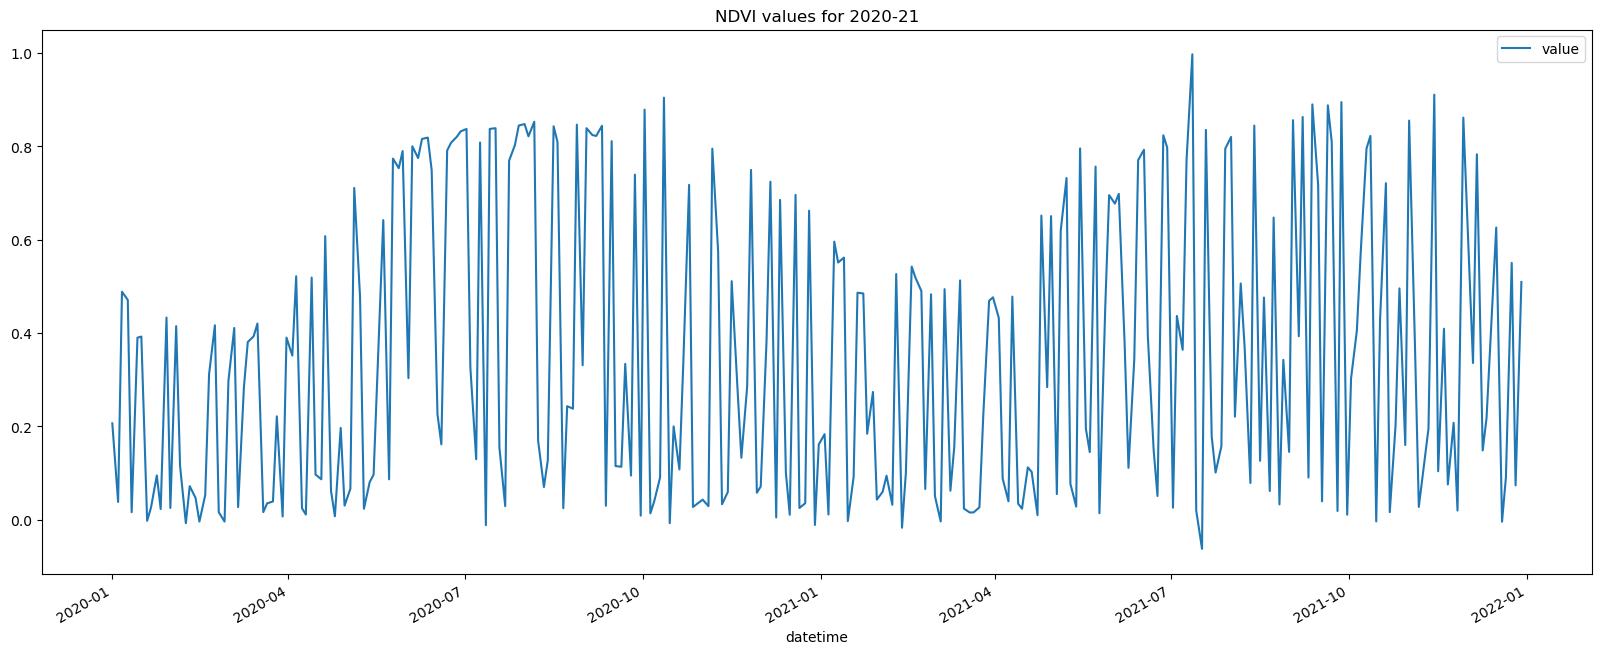

In [12]:
NDVI_title='NDVI values for 2020-21'
point_df['value']=pd.to_numeric(point_df['value'], errors='coerce')
NDVI_data = pd.DataFrame(point_df[[ 'datetime','value']]).set_index('datetime')
plot_NDVI = NDVI_data.plot.line(title=NDVI_title, figsize=(20, 8))

It's interesting to observe a sine wave pattern which is likely due to the seasonal variation in vegetation activity. NDVI values tend to oscillate over the course of a year due to changes in vegetation growth driven by factors like temperature, precipitation, and sunlight.

Next, let's define and submit a raster query to AGB Geospatial Analytics covering a square area in US for a specific date in 2023.

The query doesn't take long to complete and downloads the output as a zip file in the /download folder within the same location as this notebook.

In [15]:
query_json={
              "debug": False,
              "publish": True,
              "name": "NDVI",
              "spatial": {
                "type": "square",
                "coordinates": [
                  -38.31387,142.12049, -38.25878,142.20271
                ]
              },
              "temporal": {
                "intervals": [
                  {
                    "start": "2020-01-06 00:00:00",
                    "end": "2020-01-06 23:00:00"
                  }
                ]
              },
              "layers": [
                {
                  "type": "raster",
                  "id": "49464",
                  "output": True
                }
              ]
            }

NDVIResult = query.submit_check_status_and_download(query_json)

  

2024-06-17 11:22:34 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-17 11:22:36 - paw - INFO - The query was successfully submitted with the id: 1718582400_21156233.
2024-06-17 11:22:37 - paw - INFO - The query 1718582400_21156233 has the status Queued.
2024-06-17 11:23:08 - paw - INFO - The query 1718582400_21156233 has the status Running.
2024-06-17 11:23:38 - paw - INFO - The query 1718582400_21156233 has the status Succeeded.
2024-06-17 11:23:38 - paw - INFO - The query 1718582400_21156233 was successful after checking the status.
2024-06-17 11:24:10 - paw - INFO - The query 1718582400_21156233 has the status Succeeded.
2024-06-17 11:24:10 - paw - INFO - The query 1718582400_21156233 was successful after checking the status.
2024-06-17 11:24:10 - paw - WARNING - The query download folder download was not present on the operating system as either a fixed or relative path. Attempting to create.
2024-06-17 11:24:10 - paw - INFO - The query download folder is se

/Users/neha/Documents/GitHub/Environmental-Intelligence-internal/geospatial/v3_apis/samples/industry_usecases/download/1718582400_21156233/High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index-01_06_2020T00_00_00.tiff.json


,pixelType,pixelNoDataVal,spatialRef,boundingBox,pixelDimensions,rasterStatistics
minLatitude,fl,-9999,EPSG:4326,-38.314624,NaN,NaN
maxLatitude,fl,-9999,EPSG:4326,-38.257280,NaN,NaN
minLongitude,fl,-9999,EPSG:4326,142.119680,NaN,NaN
maxLongitude,fl,-9999,EPSG:4326,142.203648,NaN,NaN
pixelSizeDegreeLongitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
pixelSizeDegreeLatitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
numberPixelsLatitude,fl,-9999,EPSG:4326,NaN,896.000000,NaN
numberPixelsLongitude,fl,-9999,EPSG:4326,NaN,1312.000000,NaN
pixelMin,fl,-9999,EPSG:4326,NaN,NaN,-8.120000e-02
pixelMax,fl,-9999,EPSG:4326,NaN,NaN,8.357000e-01


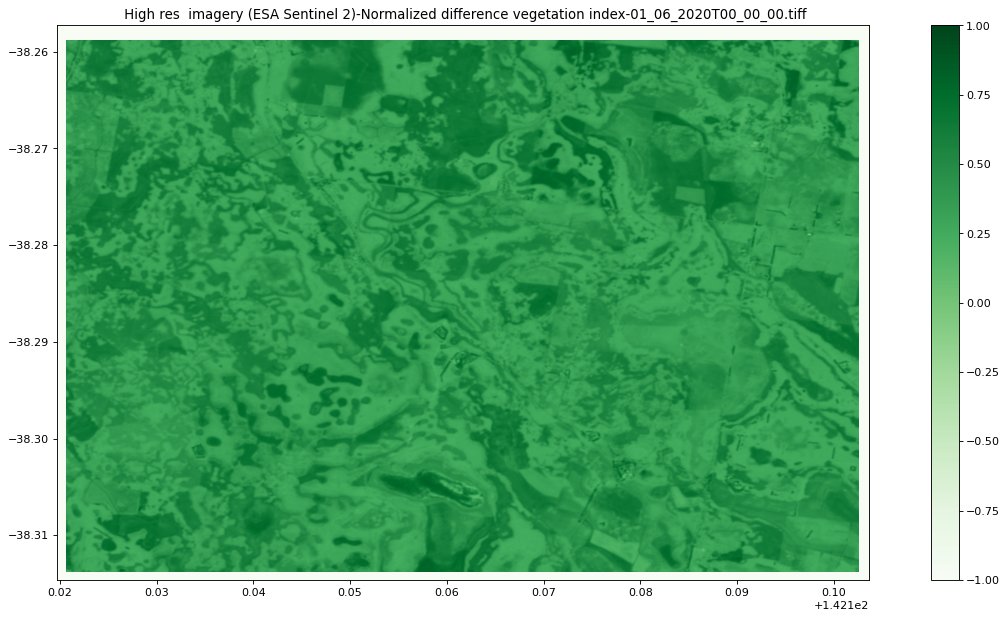

In [18]:
# Now display the resulting Tiff and summary files.
NDVIResult_File_List = NDVIResult.list_files()
for f in NDVIResult_File_List:
    if f.endswith('.tiff'): #display the raster images
        with open(f+'.json', 'r') as ff:
            fileparms = json.load(ff)
        boundingBox=fileparms["boundingBox"]
        myextent=[boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]  
        arrayNDMI = np.array(PIL.Image.open(f))
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(arrayNDMI,cmap = 'Greens', vmin=-1, vmax=1,extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(f))              
    if f.endswith('.json'):  #  show the result statistics
        print(f)
        summary=pd.read_json(f)  
        display(summary) 

/Users/neha/Documents/GitHub/Environmental-Intelligence-internal/geospatial/v3_apis/samples/industry_usecases/download/1718236800_40810494/High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index[NDVILayer]-01_06_2020T00_00_00.tiff



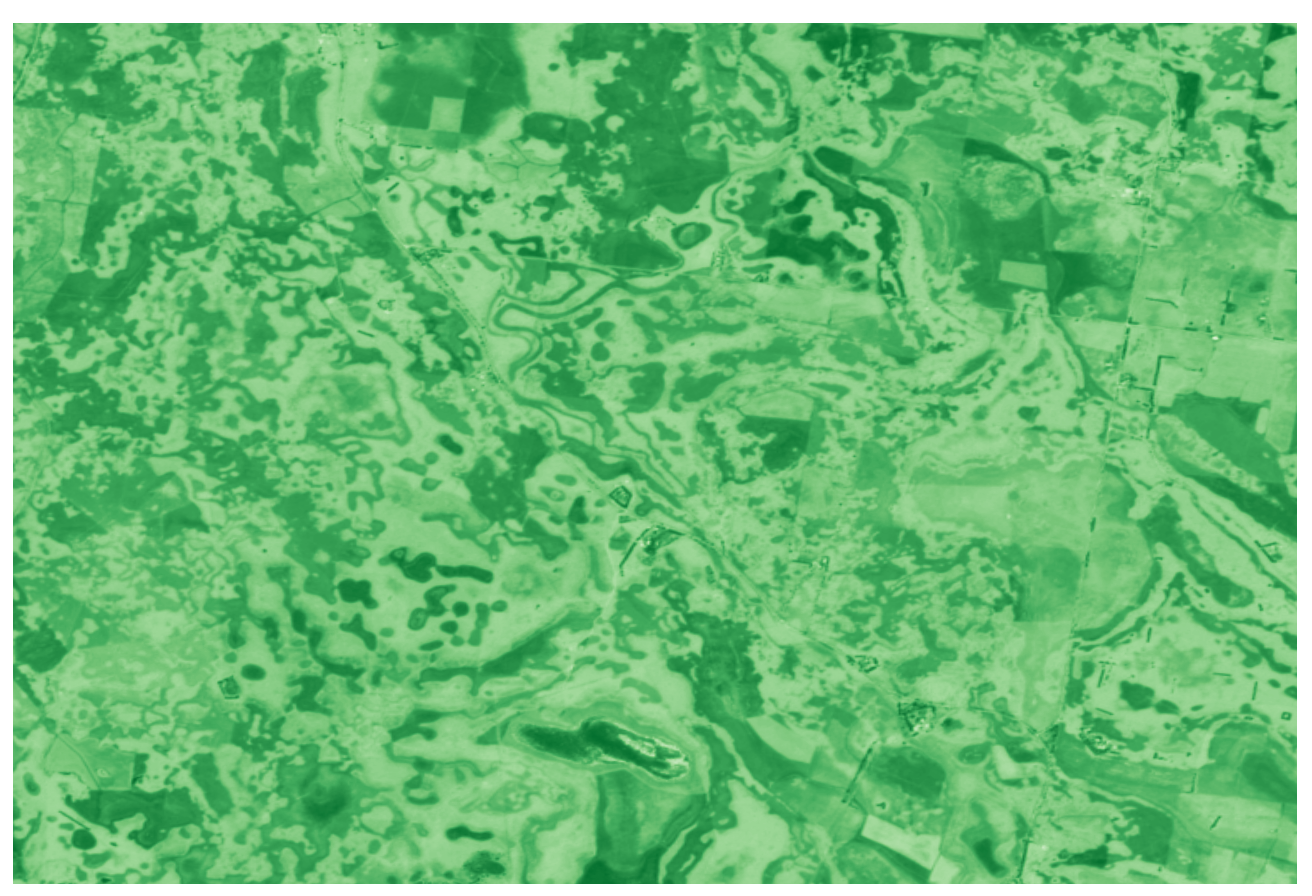

<Figure size 640x480 with 0 Axes>

In [17]:
min_lon, max_lon = 142.12049, 142.20271
min_lat, max_lat = -38.31387, -38.25878
AustraliaMap = folium.Map( max_bounds=True,
                    location=[48.7080,-104.5045],
                    zoom_start=13,
                    min_lat=min_lat,
                    max_lat=max_lat,
                    min_lon=min_lon,
                    max_lon=max_lon )

for NDVI_result_file in NDVIResult_File_List:    
    if NDVI_result_file.endswith('.tiff'):
        print(NDVI_result_file)
        with rasterio.open(NDVI_result_file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds

        with rasterio.open(NDVI_result_file) as raster_file:
            jpg_img_filename=NDVI_result_file.replace(".tiff",".jpg")
            png_img_filename=NDVI_result_file.replace(".tiff",".png")
            data = raster_file.read(1)
            data[data==-9999] = np.nan
            data[data==0] = np.nan

            cmap = plt.get_cmap('Greens')
            new_cmap_colors = cmap(np.linspace(0.2, 1, cmap.N))
            new_cmap = mcolors.LinearSegmentedColormap.from_list('DarkTerrain', new_cmap_colors)
            colored_data = (new_cmap(data) * 255).astype(np.uint8)
            plt.savefig(jpg_img_filename, bbox_inches='tight', pad_inches=0)            
            im = Image.fromarray(colored_data)
            im.save(jpg_img_filename, "PNG")

            folium.raster_layers.ImageOverlay(
                        image=jpg_img_filename,opacity=0.8,
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(AustraliaMap)
AustraliaMap